In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
month_df = df.resample('M').mean()

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


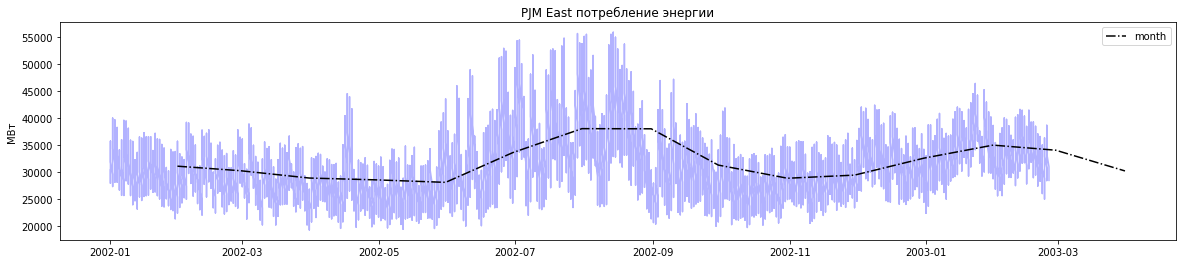

In [5]:
plt.figure(figsize =(20,4))
plt.plot( df.index[:5*24*7*4*3], df['PJME_MW'].values[:5*24*7*4*3], 'b', alpha =0.3 )
plt.plot( month_df.index[:5*3], month_df['PJME_MW'].values[:5*3], '-.k', label='month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()

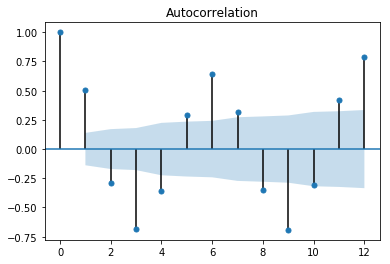

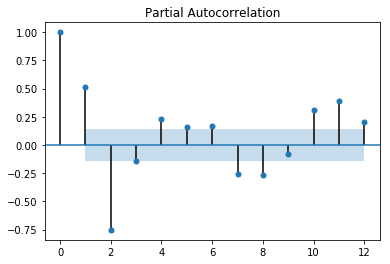

In [6]:
sm.graphics.tsa.plot_acf(month_df['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(month_df['PJME_MW'].values, lags=12)
plt.show()

In [11]:
# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs, 12]

In [12]:
mod = sm.tsa.statespace.SARIMAX(month_df['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 1, 1, 12] - AIC:2860.0715547921177


In [13]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 12)   Log Likelihood               -1425.036
Date:                            Wed, 18 Dec 2019   AIC                           2860.072
Time:                                    18:31:18   BIC                           2875.416
Sample:                                         0   HQIC                          2866.303
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

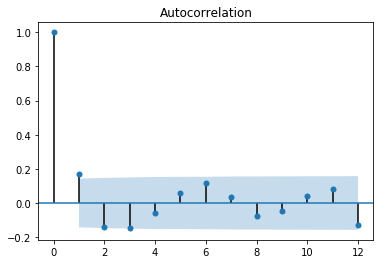

In [14]:
sm.graphics.tsa.plot_acf(results.resid, lags=12)
plt.show()

Выглядит так, будто остатки имеют некоторую корреляцию.

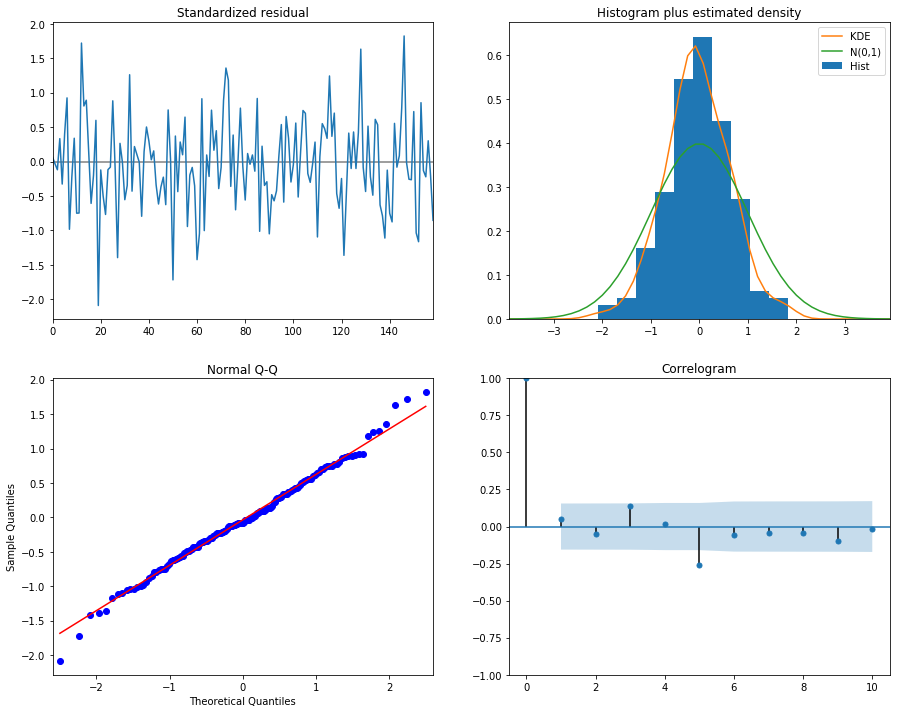

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [41]:
warnings.filterwarnings("ignore") # отключает предупреждения

best_params = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(month_df['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            best_params[results.aic] = (param, param_seasonal)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 26)26 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 26)26 - AIC:3285.657059454311
ARIMA(0, 0, 0)x(0, 0, 2, 26)26 - AIC:3680.418462036925
ARIMA(0, 0, 0)x(0, 1, 0, 26)26 - AIC:2879.425251103865
ARIMA(0, 0, 0)x(0, 1, 1, 26)26 - AIC:2339.9518911250234
ARIMA(0, 0, 0)x(0, 2, 0, 26)26 - AIC:2484.2063266048976
ARIMA(0, 0, 0)x(0, 2, 1, 26)26 - AIC:1888.4709056133684
ARIMA(0, 0, 0)x(1, 0, 0, 26)26 - AIC:2899.327202799901
ARIMA(0, 0, 0)x(1, 0, 1, 26)26 - AIC:2880.0135062256086
ARIMA(0, 0, 0)x(1, 0, 2, 26)26 - AIC:9240.772891705077
ARIMA(0, 0, 0)x(1, 1, 0, 26)26 - AIC:2351.140285803429
ARIMA(0, 0, 0)x(1, 1, 1, 26)26 - AIC:2332.2154398894527
ARIMA(0, 0, 0)x(1, 2, 0, 26)26 - AIC:1927.0384944589032
ARIMA(0, 0, 0)x(1, 2, 1, 26)26 - AIC:1899.1945235986539
ARIMA(0, 0, 0)x(2, 0, 0, 26)26 - AIC:2352.194131000001
ARIMA(0, 0, 0)x(2, 0, 1, 26)26 - AIC:2353.027023770205
ARIMA(0, 0, 0)x(2, 0, 2, 26)26 - AIC:2332.962515001857
ARIMA(0, 0, 0)x(2, 1, 0, 26)26 - AIC:1735.992525672167
AR

ARIMA(0, 2, 1)x(0, 0, 2, 26)26 - AIC:5151.462785192942
ARIMA(0, 2, 1)x(0, 1, 0, 26)26 - AIC:2844.8131389016694
ARIMA(0, 2, 1)x(0, 1, 1, 26)26 - AIC:2276.3840454882647
ARIMA(0, 2, 1)x(0, 2, 0, 26)26 - AIC:2448.167834719638
ARIMA(0, 2, 1)x(0, 2, 1, 26)26 - AIC:1839.0817231444569
ARIMA(0, 2, 1)x(1, 0, 0, 26)26 - AIC:2723.890207829033
ARIMA(0, 2, 1)x(1, 0, 1, 26)26 - AIC:2679.0318894658776
ARIMA(0, 2, 1)x(1, 0, 2, 26)26 - AIC:4275.905336227582
ARIMA(0, 2, 1)x(1, 1, 0, 26)26 - AIC:2334.7779507308087
ARIMA(0, 2, 1)x(1, 1, 1, 26)26 - AIC:2234.4533329342144
ARIMA(0, 2, 1)x(1, 2, 0, 26)26 - AIC:1897.912658662971
ARIMA(0, 2, 1)x(1, 2, 1, 26)26 - AIC:1834.8872058327665
ARIMA(0, 2, 1)x(2, 0, 0, 26)26 - AIC:2211.558598772104
ARIMA(0, 2, 1)x(2, 0, 1, 26)26 - AIC:2206.7081267711833
ARIMA(0, 2, 1)x(2, 0, 2, 26)26 - AIC:4488.306116347163
ARIMA(0, 2, 1)x(2, 1, 0, 26)26 - AIC:1712.4361603295765
ARIMA(0, 2, 1)x(2, 1, 1, 26)26 - AIC:1713.937600383643
ARIMA(0, 2, 1)x(2, 2, 0, 26)26 - AIC:1328.4079788029374


ARIMA(1, 1, 2)x(0, 1, 1, 26)26 - AIC:2208.566456448659
ARIMA(1, 1, 2)x(0, 2, 0, 26)26 - AIC:2355.7846463984383
ARIMA(1, 1, 2)x(0, 2, 1, 26)26 - AIC:1785.9320574113099
ARIMA(1, 1, 2)x(1, 0, 0, 26)26 - AIC:2649.934912711823
ARIMA(1, 1, 2)x(1, 0, 1, 26)26 - AIC:2602.198985346991
ARIMA(1, 1, 2)x(1, 0, 2, 26)26 - AIC:nan
ARIMA(1, 1, 2)x(1, 1, 0, 26)26 - AIC:2259.595520505968
ARIMA(1, 1, 2)x(1, 1, 1, 26)26 - AIC:2179.405377441593
ARIMA(1, 1, 2)x(1, 2, 0, 26)26 - AIC:1841.864972435759
ARIMA(1, 1, 2)x(1, 2, 1, 26)26 - AIC:1728.6598192691756
ARIMA(1, 1, 2)x(2, 0, 0, 26)26 - AIC:2156.682614213309
ARIMA(1, 1, 2)x(2, 0, 1, 26)26 - AIC:2150.4462965335915
ARIMA(1, 1, 2)x(2, 0, 2, 26)26 - AIC:2106.4270920021977
ARIMA(1, 1, 2)x(2, 1, 0, 26)26 - AIC:1692.9844523170295
ARIMA(1, 1, 2)x(2, 1, 1, 26)26 - AIC:1694.0356680552202
ARIMA(1, 1, 2)x(2, 2, 0, 26)26 - AIC:1241.8072374565031
ARIMA(1, 1, 2)x(2, 2, 1, 26)26 - AIC:1233.7206908053884
ARIMA(1, 2, 0)x(0, 0, 0, 26)26 - AIC:3252.358901834961
ARIMA(1, 2, 0)x

ARIMA(2, 1, 0)x(1, 0, 1, 26)26 - AIC:2644.7019771468767
ARIMA(2, 1, 0)x(1, 0, 2, 26)26 - AIC:5224.152996574915
ARIMA(2, 1, 0)x(1, 1, 0, 26)26 - AIC:2203.2093488763658
ARIMA(2, 1, 0)x(1, 1, 1, 26)26 - AIC:2200.8414902773843
ARIMA(2, 1, 0)x(1, 2, 0, 26)26 - AIC:1778.515122718331
ARIMA(2, 1, 0)x(1, 2, 1, 26)26 - AIC:1768.7715949444973
ARIMA(2, 1, 0)x(2, 0, 0, 26)26 - AIC:2148.663982138852
ARIMA(2, 1, 0)x(2, 0, 1, 26)26 - AIC:2130.2622161041213
ARIMA(2, 1, 0)x(2, 0, 2, 26)26 - AIC:2129.6101529387042
ARIMA(2, 1, 0)x(2, 1, 0, 26)26 - AIC:1668.876736575566
ARIMA(2, 1, 0)x(2, 1, 1, 26)26 - AIC:1669.195126143132
ARIMA(2, 1, 0)x(2, 2, 0, 26)26 - AIC:1219.347800142795
ARIMA(2, 1, 0)x(2, 2, 1, 26)26 - AIC:1206.8167834450596
ARIMA(2, 1, 1)x(0, 0, 0, 26)26 - AIC:3021.738772903671
ARIMA(2, 1, 1)x(0, 0, 1, 26)26 - AIC:2556.538200449948
ARIMA(2, 1, 1)x(0, 0, 2, 26)26 - AIC:5120.18004342238
ARIMA(2, 1, 1)x(0, 1, 0, 26)26 - AIC:2668.2732281620056
ARIMA(2, 1, 1)x(0, 1, 1, 26)26 - AIC:2143.034568701433
ARI

In [48]:
best_params[min(best_params)]

((2, 1, 0), (2, 2, 1, 26))

In [16]:
mod = sm.tsa.statespace.SARIMAX(month_df['PJME_MW'].values[:-12],order=[2,1,0],
                                seasonal_order=[2,2,1,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}', results_opt.aic)

AIC:{} 2472.125521737272


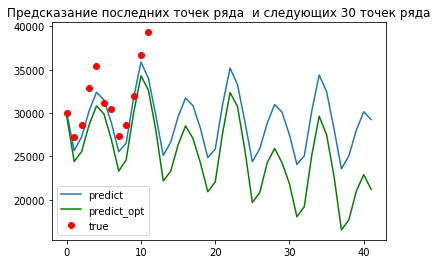

In [17]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(month_df['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

Предсказание выглядит неплохо, но на недельном ресемплинге значения были ближе.